In [2]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import itertools
import pickle
import shutil
import glob
import math
import csv
import sys
import os
import re
from upsetplot import plot as uplot

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import matplotlib.pylab as pylab
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 1

sys.path.insert(0, "./soft")
%aimport definitions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
base_dir = "./reviews/"
data_dir = base_dir+"data/"
chess3_data_dir = "./"
out_dir = base_dir+"reviews/"

gff3cols = ["seqid","source","type","start","end","score","strand","phase","attributes"]

In [7]:
chess3_full_gtf_fname = data_dir+"chess3/chess3.0.gtf"
chess2_gtf_fname = data_dir+"chess2.2.gtf"
all_full_gtf_fname = data_dir+"all.gtf"
tb_full_gtf_fname = data_dir+"assembled.gtf"
refseq_full_gtf_fname = data_dir+"refseq.gtf" # 110 - same as preprint/steven
gencode_full_gtf_fname = data_dir+"gencode.gtf" # 41 - same as preprint
mane_full_gtf_fname = data_dir+"MANE.v10.gtf"

chm13_chess3_gtf_fname = data_dir+"chess3/chess3.0.CHM13.gtf"
chm13_gencode_gtf_fname = data_dir+"chm13.draft_v2.0.gene_annotation.gtf"

In [8]:
# create pure subsets of reference scaffolds only for each dataset including 27m, 1m, chess3
seqids = set(["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9",
              "chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19",
              "chr20","chr21","chr22","chrX","chrY"])
definitions.subset_gtf_by_seqid(refseq_full_gtf_fname,refseq_full_gtf_fname.strip(".gtf")+".pri.gtf",seqids)
definitions.subset_gtf_by_seqid(gencode_full_gtf_fname,gencode_full_gtf_fname.strip(".gtf")+".pri.gtf",seqids)
definitions.subset_gtf_by_seqid(chess3_full_gtf_fname,chess3_full_gtf_fname.strip(".gtf")+".pri.gtf",seqids)
definitions.subset_gtf_by_seqid(mane_full_gtf_fname,mane_full_gtf_fname.strip(".gtf")+".pri.gtf",seqids)
definitions.subset_gtf_by_seqid(all_full_gtf_fname,all_full_gtf_fname.strip(".gtf")+".pri.gtf",seqids)
definitions.subset_gtf_by_seqid(tb_full_gtf_fname,tb_full_gtf_fname.strip(".gtf")+".pri.gtf",seqids)

In [9]:
chess3_gtf_fname = chess3_full_gtf_fname.strip(".gtf")+".pri.gtf"
refseq_gtf_fname = refseq_full_gtf_fname.strip(".gtf")+".pri.gtf"
gencode_gtf_fname = gencode_full_gtf_fname.strip(".gtf")+".pri.gtf"
mane_gtf_fname = mane_full_gtf_fname.strip(".gtf")+".pri.gtf"
all_gtf_fname = all_full_gtf_fname.strip(".gtf")+".pri.gtf"
tb_gtf_fname = tb_full_gtf_fname.strip(".gtf")+".pri.gtf"

In [8]:
c3a_gtf = extract_all_attributes(chess3_gtf_fname,"transcript")
print(list(c3a_gtf))
print(c3a_gtf["gene_type"])
print(c3a_gtf["tag"])

['transcript_id', 'gene_id', 'gene_type', 'gene_name', 'db_xref', 'num_samples', 'max_tpm', 'assembly_id', 'tag']
{'transcribed_pseudogene': 1688, 'miRNA': 4787, 'lncRNA': 34581, 'pseudogene': 15277, 'protein_coding': 99137, 'snRNA': 148, 'snoRNA': 1194, 'antisense_RNA': 37, 'ncRNA': 28, 'tRNA': 429, 'TEC': 28, 'ncRNA_pseudogene': 1, 'misc_RNA': 61, 'V_segment': 235, 'rRNA': 29, 'other': 14, 'C_region': 23, 'J_segment': 98, 'V_segment_pseudogene': 189, 'telomerase_RNA': 1, 'vault_RNA': 4, 'D_segment': 32, 'J_segment_pseudogene': 7, 'Y_RNA': 4, 'RNase_MRP_RNA': 1, 'scRNA': 4, 'RNase_P_RNA': 1, 'C_region_pseudogene': 5}
{'MANE_Select': 19043, 'partial': 397, 'MANE_Select,duplicated_transcript': 77, 'duplicated_transcript': 175}


In [9]:
# Source stats
c3 = definitions.load_gtf(chess3_gtf_fname)
c3 = c3[c3["type"]=="transcript"].reset_index(drop=True)
c3g = pd.DataFrame(c3[["source","type"]].groupby(by="source").count()).reset_index()
c3g.columns = ["source","count"]
c3g

,source,count
0,BestRefSeq,64932
1,Curated Genomic,14991
2,ENSEMBL,109
3,FANTOM,318
4,Gnomon,15301
5,HAVANA,8047
6,StringTie,33675
7,cmsearch,1121
8,ensembl,2
9,ensembl_havana,14981


In [10]:
# reviewer 2 comment 1 : count the number of transcripts at each step of the analysis

# Going back through my scripts – this section of supplement is a bit outdated. Prior to release 2.9.014 we used the procedure as described in the supplement (applying TPM and sample count thresholds to both multi and single exon transcripts). However, since 2.9.014 we’ve decided on exclusively using tiebrush filtering for multi-exon transcripts, no matter their TPM and sample count. The minimum sample is still being used to filter single-exon transcripts. Single-exon transcripts are also being filtered by TPM such as: 1.5*IQR (of TPM of multi-exon transcripts in that tissue) 

# This filtering is difficult to quantify since the temporarily generated files have been deleted. 

# The 10% of the highest expressed transcript at locus was not done by me – not sure how to quantify the number filtered out. 

# Same for the filtering based on the length of the ORF compared to the longest/canonical ORF at the locus. 

# Breakdown of numbers based on other filtering steps. 

# ALL - 987,244 

# TieBrushed -  

# Known -  

# 	we removed additional 1268 read-through 

# 	and 19619 with no start or stop codons found by ORFanage 

# 	and 4670 with no phylocsf support 

 

# Novel 

# 	ML-selected 

 

# 		of those we removed the 62076 low-confidence 

# 		of the remaining we removed additional 10,457 read-through 

# 		and 20021 with no start or stop codons found by ORFanage 

# 		and 10,201 with no phylocsf support 

In [ ]:
# reviewer 2 comment 4 : how many transcripts did we observe in 27M how many in 1M how many in final (run for both gencode and refseq)

# let's just build a giant upset plot

if not os.path.exists(out_dir+"gffcmp/"):
    os.makedirs(out_dir+"gffcmp/")
    
raw_gtf_list = [tuple(["GENCODE",gencode_gtf_fname]),
                tuple(["RefSeq",refseq_gtf_fname]),
                tuple(["MANE",mane_gtf_fname]),
                tuple(["Assembled",all_gtf_fname]),
                tuple(["TieBrush",tb_gtf_fname]),
                tuple(["CHESS3",chess3_gtf_fname])]

setup_fname = out_dir+"gffcmp/gffcmp_multi.setup.csv"
with open(setup_fname,"w+") as setup_fp:
    for label,fname in raw_gtf_list:
        setup_fp.write(label+","+fname+"\n")

gcm_cmd = [chess3_data_dir+"soft/scripts/genomic_scripts/gffcmp_multi/gffcmp_multi.py",
           "-s",out_dir+"gffcmp/gffcmp_multi.setup.csv",
           "-o",out_dir+"gffcmp/",
           "--keep-tmp",
           "--threads","10"]
print(" ".join(gcm_cmd))
subprocess.call(gcm_cmd)

In [ ]:
assert os.path.exists(out_dir+"gffcmp/"),"output path is incorrect"

# run gffread on all inputs to standardize them
gtf_list = list()
labels = []
for label,path in raw_gtf_list:
    assert os.path.exists(path),"input file does not exist: "+path
    gtf_list.append(tuple([label,out_dir+"gffcmp/"+label+".gtf"]))
    labels.append(label)

gtf_pairs = list(itertools.permutations(gtf_list, 2))

In [ ]:
# cycle through annotations and load all transcripts in
tx_map = dict()
for gp in gtf_pairs:
    print(gp)
    gtf_fname = gp[0][1]
    rn = gp[0][0]
    tn = gp[1][0]
    tx_map.setdefault(rn, dict())
    tx_map[rn].setdefault(tn, dict())
    with open(gtf_fname, "r") as inFP:
        for line in inFP:
            cols = line.strip().split("\t")
            if cols[2] != "transcript":
                continue
            attrs = cols[8]
            tmp = attrs.split("transcript_id \"", 1)
            if len(tmp) == 1:
                continue
            tid = tmp[-1].split("\"", 1)[0]
            tx_map[rn][tn][tid] = None

# get complete map between all transcripts in comparison   
print("map")
for gp in gtf_pairs:
    print(gp)
    rn = gp[0][0]
    tn = gp[1][0]
    refmap_fname = out_dir+"gffcmp/" + rn + "_" + tn + ".refmap"
    with open(refmap_fname, "r") as inFP:
        for line in inFP:
            cols = line.strip().split("\t")
            code = cols[2]
            if not code == "=":
                continue
            rtid = cols[1]
            ttids = [x.split("|")[1] for x in cols[3].split(",")]
            assert rtid in tx_map[rn][tn], "tid not preloaded: " + rtid + " for " + rn + "/" + tn
            assert tx_map[rn][tn][rtid] is None, "duplicates in: " + rtid
            tx_map[rn][tn][rtid] = ttids

In [14]:
# save results: pickle?
with open(out_dir+"gffcmp/tx_map.pickle", 'wb') as fp:
    pickle.dump(tx_map, fp)

In [10]:
tx_map = dict()
with open(out_dir+"gffcmp/tx_map.pickle", 'rb') as fp:
    tx_map = pickle.load(fp)
print(list(tx_map))

['GENCODE', 'RefSeq', 'MANE', 'Assembled', 'TieBrush', 'CHESS3']


In [13]:
def get_combs(names):
    all_combinations = [list(itertools.combinations(names, x)) for x in range(1, len(names) + 1)]
    res = list()
    for comb_set in all_combinations:
        for comb in comb_set:
            res.append([list(set(comb)), list(set(names) - set(comb))])

    return res

def get_mat(names,keep_all_false=True):
    tmp = list(itertools.product([False, True], repeat=len(names)))
    index = pd.MultiIndex.from_tuples(tmp, names=names)
    series = pd.Series(np.zeros(len(tmp)), index=index)
    if not keep_all_false:
        series = series[~(series==False)] # remove the first row with all Falses
    return series

def get_not_none(d):
    res = set()
    for k, v in d.items():
        if v is not None:
            res.add(k)

    return res

def get_set(tm, c, c_rev):  # get transcripts in c but not in union of c_rev
    res = set(tm[c[0]][list(tm[c[0]])[0]])
    for name in c:  # from requested union
        if name == c[0]:  # skip itself
            continue

        res = res.intersection(get_not_none(tm[c[0]][name]))

    for name in c_rev:  # remove unwanted
        res = res - get_not_none(tm[c[0]][name])

    return res

In [ ]:
print("combs")
combs = get_combs(list(tx_map))
print("mat")
mat = get_mat(list(tx_map),False)
print("index")
index_names = mat.index.names

for comb, comb_rev in combs:
    res = get_set(tx_map, comb, comb_rev)
    idx_loc = tuple([True if x in comb else False for x in index_names])
    mat.loc[idx_loc] = len(res)

mat.to_csv(out_dir+"gffcmp/figs/tx.csv")

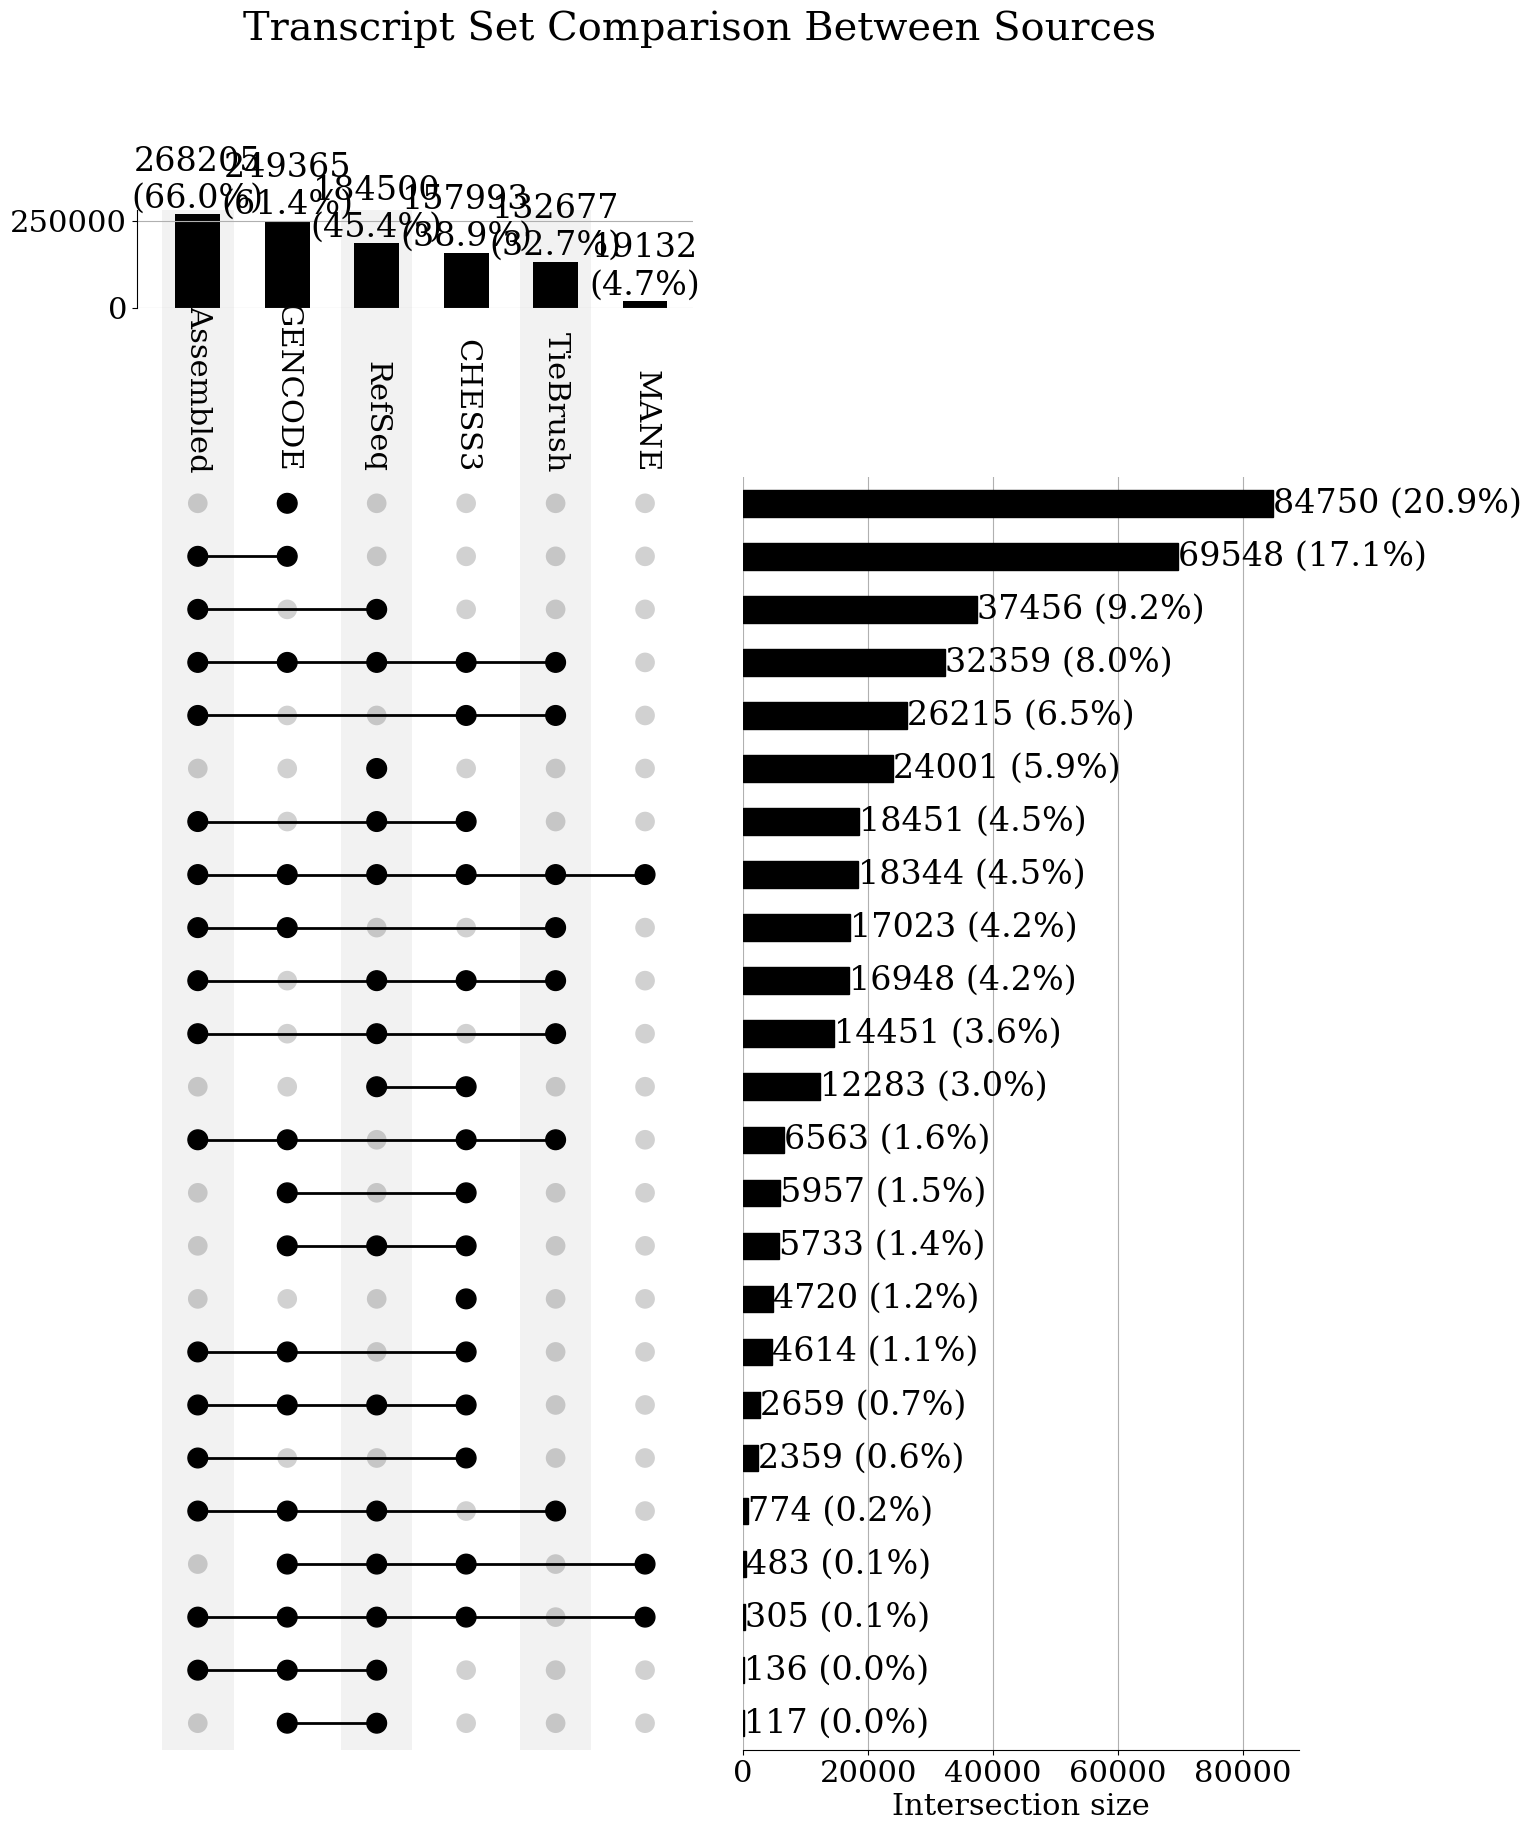

In [58]:
tmp = pd.read_csv(out_dir+"gffcmp/figs/tx.mod.csv",index_col=[0,1,2,3,4,5])
tmp = tmp.squeeze()

params = {'figure.figsize': (40,5),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)

fig = plt.figure(figsize=(15,20))

uplot(tmp,show_percentages=True,show_counts=True,sort_by="cardinality",fig=fig, element_size=None,orientation="vertical")
plt.suptitle('Transcript Set Comparison Between Sources')
plt.savefig(out_dir+"gffcmp/figs/tx.svg")

# we manually edited out all lines with 0 in them, all Assembled and TieBrush output that is not found elsewhere and 
# 3 MANE polycistronic transcripts which were not matched properly due to de-duplication by gffcompare


RefSeq XM total: 65919
RefSeq NM total: 63738
TieBrush XM match: 15049
TieBrush NM match: 46711
Assembled XM match: 48054
Assembled NM match: 59041
GENCODE XM match: 2401
GENCODE NM match: 42441


,count,type,Dataset
0,65919,XM,RefSeq
1,63738,NM,RefSeq
2,9750,XM,CHESS 3
3,63103,NM,CHESS 3
4,15049,XM,TieBrush
5,46711,NM,TieBrush
6,48054,XM,Assembled
7,59041,NM,Assembled
8,2401,XM,GENCODE
9,42441,NM,GENCODE


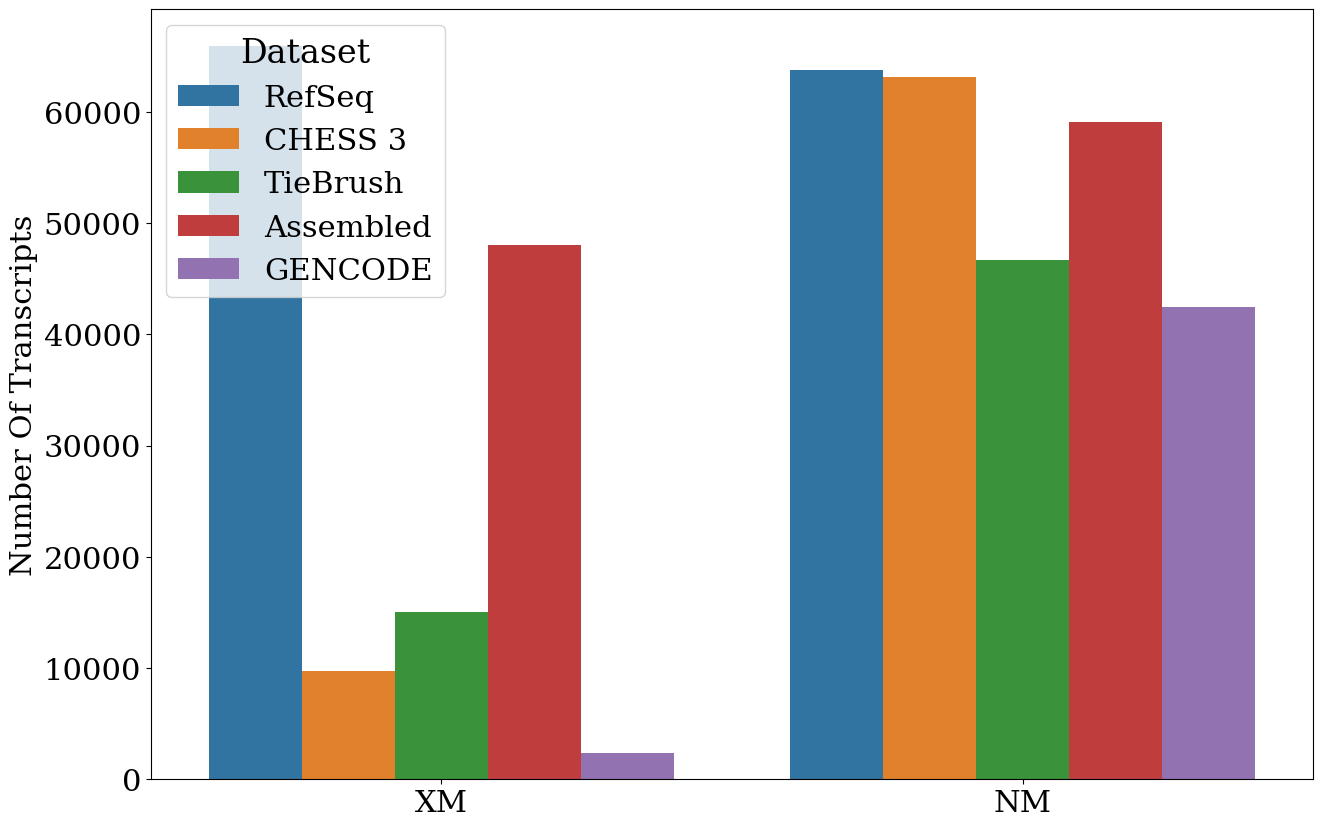

In [94]:
# reviewer 2 major comment 1: count the number of XM and NMs that we have
#  - mention in methods and in supplement
#     - in the supplement. We included all XM but for NM we only included those that were confirmed in our analysis

# from the refseq to chess3 comparison - check number of xm and nm
# by simple grep "XM_" and grep "NM_" we have 9749 XM and 63099

def get_xm_nm(in_gtf_fname):
    xms = {"total":set(),
           "match":set()}
    nms = {"total":set(),
           "match":set()}
    with open(in_gtf_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if not len(lcs) == 9:
                continue

            if lcs[2]=="transcript":
                tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
                tag = None
                try:
                    tag = tid.split("rna-")[1].split("_")[0]
                    if not tag in ["XM","NM"]:
                        continue
                except: # not XM/NM
                    continue

                cc = lcs[8].split("class_code \"", 1)[1].split("\"", 1)[0]

                if tag=="XM":
                    xms["total"].add(tid)
                    if cc=="=":
                        xms["match"].add(tid)
                if tag=="NM":
                    nms["total"].add(tid)
                    if cc=="=":
                        nms["match"].add(tid)
    
    return xms,nms
    
c3_xms,c3_nms = get_xm_nm(out_dir+"gffcmp/CHESS3_RefSeq.annotated.gtf")
tb_xms,tb_nms = get_xm_nm(out_dir+"gffcmp/TieBrush_RefSeq.annotated.gtf")
all_xms,all_nms = get_xm_nm(out_dir+"gffcmp/Assembled_RefSeq.annotated.gtf")
gencode_xms,gencode_nms = get_xm_nm(out_dir+"gffcmp/GENCODE_RefSeq.annotated.gtf")

print("RefSeq XM total: "+str(len(c3_xms["total"])))
print("RefSeq NM total: "+str(len(c3_nms["total"])))

print("TieBrush XM match: "+str(len(tb_xms["match"])))
print("TieBrush NM match: "+str(len(tb_nms["match"])))

print("Assembled XM match: "+str(len(all_xms["match"])))
print("Assembled NM match: "+str(len(all_nms["match"])))

print("GENCODE XM match: "+str(len(gencode_xms["match"])))
print("GENCODE NM match: "+str(len(gencode_nms["match"])))

# plot these counts as a bar chart
df = pd.DataFrame([],columns=["count","type","Dataset"])
df.loc[len(df.index)]=[len(c3_xms["total"]),"XM","RefSeq"]
df.loc[len(df.index)]=[len(c3_nms["total"]),"NM","RefSeq"]
df.loc[len(df.index)]=[len(c3_xms["match"]),"XM","CHESS 3"]
df.loc[len(df.index)]=[len(c3_nms["match"]),"NM","CHESS 3"]
df.loc[len(df.index)]=[len(tb_xms["match"]),"XM","TieBrush"]
df.loc[len(df.index)]=[len(tb_nms["match"]),"NM","TieBrush"]
df.loc[len(df.index)]=[len(all_xms["match"]),"XM","Assembled"]
df.loc[len(df.index)]=[len(all_nms["match"]),"NM","Assembled"]
df.loc[len(df.index)]=[len(gencode_xms["match"]),"XM","GENCODE"]
df.loc[len(df.index)]=[len(gencode_nms["match"]),"NM","GENCODE"]
display(df)

params = {'figure.figsize': (15,10),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)
sns.barplot(data=df,y="count", x="type", hue="Dataset")
plt.ylabel("Number Of Transcripts")
plt.xlabel("")
plt.savefig(out_dir+"gffcmp/figs/xm_nm.svg")

In [19]:
# what are the NMs which we do not have?
print("missing from CHESS 3: "+str(len(c3_nms["total"]-c3_nms["match"])))
c3_nms["total"]-c3_nms["match"]

missing from CHESS 3: 635


{'rna-NM_001001392.2',
 'rna-NM_001001666.4',
 'rna-NM_001001715.4',
 'rna-NM_001001734.2',
 'rna-NM_001002810.5',
 'rna-NM_001002844.3',
 'rna-NM_001005176.3',
 'rna-NM_001005526.2',
 'rna-NM_001005915.1',
 'rna-NM_001006623.4',
 'rna-NM_001007246.3',
 'rna-NM_001007250.3',
 'rna-NM_001007470.3',
 'rna-NM_001012505.2',
 'rna-NM_001013258.2',
 'rna-NM_001017397.2',
 'rna-NM_001017398.2',
 'rna-NM_001023587.3',
 'rna-NM_001024074.3',
 'rna-NM_001025068.1',
 'rna-NM_001025069.1',
 'rna-NM_001029839.3',
 'rna-NM_001029840.3',
 'rna-NM_001032374.2',
 'rna-NM_001033505.2',
 'rna-NM_001033506.2',
 'rna-NM_001035230.3',
 'rna-NM_001035516.4',
 'rna-NM_001039210.5',
 'rna-NM_001039477.3',
 'rna-NM_001039938.2',
 'rna-NM_001042365.4',
 'rna-NM_001044390.3',
 'rna-NM_001044391.3',
 'rna-NM_001044392.3',
 'rna-NM_001044393.3',
 'rna-NM_001079528.4',
 'rna-NM_001100620.3',
 'rna-NM_001105208.3',
 'rna-NM_001105209.3',
 'rna-NM_001113201.3',
 'rna-NM_001113202.2',
 'rna-NM_001126336.3',
 'rna-NM_00

In [20]:
# check 224 genes and where they ended up

# get the 224 genes: awk -F'\t' '$1=="protein_coding" && ($5=="CHESS" || $5=="FANTOM")' chess2.2.genes | cut -f3 > 224.genes

# load genes and create subset from the chess2 file for comparison
gids = set()
with open(data_dir+"224.genes","r") as inFP:
    for line in inFP:
        gids.add(line.strip())

print(len(gids))

# create subset of the chess2 file with these genes
definitions.subset_gtf(chess2_gtf_fname,data_dir+"224.gtf",gids,False)

224


In [ ]:
# run gffcmp for these transcripts to see what's up
if not os.path.exists(out_dir+"gffcmp_224/"):
    os.makedirs(out_dir+"gffcmp_224/")
    
cmd = ["gffcompare","--no-merge","-o",out_dir+"gffcmp_224/224_CHESS3","-r",chess3_gtf_fname,data_dir+"224.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
shutil.move(data_dir+"224_CHESS3.224.gtf.refmap",out_dir+"gffcmp_224/224_CHESS3.refmap")
shutil.move(data_dir+"224_CHESS3.224.gtf.tmap",out_dir+"gffcmp_224/224_CHESS3.tmap")

cmd = ["gffcompare","--no-merge","-o",out_dir+"gffcmp_224/224_RefSeq","-r",refseq_gtf_fname,data_dir+"224.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
shutil.move(data_dir+"224_RefSeq.224.gtf.refmap",out_dir+"gffcmp_224/224_RefSeq.refmap")
shutil.move(data_dir+"224_RefSeq.224.gtf.tmap",out_dir+"gffcmp_224/224_RefSeq.tmap")

cmd = ["gffcompare","--no-merge","-o",out_dir+"gffcmp_224/224_GENCODE","-r",gencode_gtf_fname,data_dir+"224.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
shutil.move(data_dir+"224_GENCODE.224.gtf.refmap",out_dir+"gffcmp_224/224_GENCODE.refmap")
shutil.move(data_dir+"224_GENCODE.224.gtf.tmap",out_dir+"gffcmp_224/224_GENCODE.tmap")

cmd = ["gffcompare","--no-merge","-o",out_dir+"gffcmp_224/224_Assembled","-r",all_gtf_fname,data_dir+"224.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
shutil.move(data_dir+"224_Assembled.224.gtf.refmap",out_dir+"gffcmp_224/224_Assembled.refmap")
shutil.move(data_dir+"224_Assembled.224.gtf.tmap",out_dir+"gffcmp_224/224_Assembled.tmap")

cmd = ["gffcompare","--no-merge","-o",out_dir+"gffcmp_224/224_TieBrush","-r",tb_gtf_fname,data_dir+"224.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
shutil.move(data_dir+"224_TieBrush.224.gtf.refmap",out_dir+"gffcmp_224/224_TieBrush.refmap")
shutil.move(data_dir+"224_TieBrush.224.gtf.tmap",out_dir+"gffcmp_224/224_TieBrush.tmap")

cmd = ["gffcompare","--no-merge","-o",out_dir+"gffcmp_224/224_MANE","-r",mane_gtf_fname,data_dir+"224.gtf"]
print(" ".join(cmd))
subprocess.call(cmd)
shutil.move(data_dir+"224_MANE.224.gtf.refmap",out_dir+"gffcmp_224/224_MANE.refmap")
shutil.move(data_dir+"224_MANE.224.gtf.tmap",out_dir+"gffcmp_224/224_MANE.tmap")

In [22]:
# how many match? class codes (=,c,k,m,n,j)
pass_codes = ["=","c","k","m","n","j"]

mane_224 = definitions.load_map(out_dir+"gffcmp_224/224_MANE.annotated.gtf","224","MANE",pass_codes)
mane_224["gid"] = "CHS."+mane_224["224"].str.split(".",expand=True)[1]
print("MANE: number of genes with at least one matching transcript: "+str(len(set(mane_224[mane_224["code"]=="="]["gid"]))))
print("MANE: number of genes with at least one related transcript (=,c,k,m,n,j): "+str(len(set(mane_224["gid"]))))

c3_224 = definitions.load_map(out_dir+"gffcmp_224/224_CHESS3.annotated.gtf","224","CHESS3",pass_codes)
c3_224["gid"] = "CHS."+c3_224["224"].str.split(".",expand=True)[1]
print("CHESS3: number of genes with at least one matching transcript: "+str(len(set(c3_224[c3_224["code"]=="="]["gid"]))))
print("CHESS3: number of genes with at least one related transcript (=,c,k,m,n,j): "+str(len(set(c3_224["gid"]))))

gencode_224 = definitions.load_map(out_dir+"gffcmp_224/224_GENCODE.annotated.gtf","224","GENCODE",pass_codes)
gencode_224["gid"] = "CHS."+gencode_224["224"].str.split(".",expand=True)[1]
print("GENCODE: number of genes with at least one matching transcript: "+str(len(set(gencode_224[gencode_224["code"]=="="]["gid"]))))
print("GENCODE: number of genes with at least one related transcript (=,c,k,m,n,j): "+str(len(set(gencode_224["gid"]))))

refseq_224 = definitions.load_map(out_dir+"gffcmp_224/224_RefSeq.annotated.gtf","224","RefSeq",pass_codes)
refseq_224["gid"] = "CHS."+refseq_224["224"].str.split(".",expand=True)[1]
print("RefSeq: number of genes with at least one matching transcript: "+str(len(set(refseq_224[refseq_224["code"]=="="]["gid"]))))
print("RefSeq: number of genes with at least one related transcript (=,c,k,m,n,j): "+str(len(set(refseq_224["gid"]))))

all_224 = definitions.load_map(out_dir+"gffcmp_224/224_Assembled.annotated.gtf","224","Assembled",pass_codes)
all_224["gid"] = "CHS."+all_224["224"].str.split(".",expand=True)[1]
print("All Assembled: number of genes with at least one matching transcript: "+str(len(set(all_224[all_224["code"]=="="]["gid"]))))
print("All Assembled: number of genes with at least one related transcript (=,c,k,m,n,j): "+str(len(set(all_224["gid"]))))

tb_224 = definitions.load_map(out_dir+"gffcmp_224/224_TieBrush.annotated.gtf","224","TieBrush",pass_codes)
tb_224["gid"] = "CHS."+tb_224["224"].str.split(".",expand=True)[1]
print("TieBrush-filtered: number of genes with at least one matching transcript: "+str(len(set(tb_224[tb_224["code"]=="="]["gid"]))))
print("TieBrush-filtered: number of genes with at least one related transcript (=,c,k,m,n,j): "+str(len(set(tb_224["gid"]))))

# ned to +1 for the single-exon match

MANE: number of genes with at least one matching transcript: 2
MANE: number of genes with at least one related transcript (=,c,k,m,n,j): 4
CHESS3: number of genes with at least one matching transcript: 19
CHESS3: number of genes with at least one related transcript (=,c,k,m,n,j): 46
GENCODE: number of genes with at least one matching transcript: 19
GENCODE: number of genes with at least one related transcript (=,c,k,m,n,j): 52
RefSeq: number of genes with at least one matching transcript: 9
RefSeq: number of genes with at least one related transcript (=,c,k,m,n,j): 22
All Assembled: number of genes with at least one matching transcript: 150
All Assembled: number of genes with at least one related transcript (=,c,k,m,n,j): 185
TieBrush-filtered: number of genes with at least one matching transcript: 82
TieBrush-filtered: number of genes with at least one related transcript (=,c,k,m,n,j): 142


In [23]:
# load gene biotypes from gencode chm13

chm13_gencode_biotypes = definitions.get_attribute(chm13_gencode_gtf_fname,["gene_biotype","gene_id"])
chm13_gencode_biotypes.drop("tid",axis=1,inplace=True)
chm13_gencode_biotypes.drop_duplicates(inplace=True)
chm13_gencode_biotypes.reset_index(drop=True,inplace=True)
chm13_gencode_biotypes = chm13_gencode_biotypes.groupby(by="gene_biotype").count().reset_index()
chm13_gencode_biotypes.columns = ["gene_biotype","count"]
chm13_gencode_biotypes.sort_values(by="count",ascending=False)

,gene_biotype,count
22,protein_coding,20067
17,lncRNA,17578
21,processed_pseudogene,10918
39,unprocessed_pseudogene,2969
19,misc_RNA,2231
18,miRNA,2046
30,snRNA,1902
11,TEC,1341
34,transcribed_unprocessed_pseudogene,1012
24,rRNA,1007


In [24]:
# load gene biotypes from chess3

chess3_biotypes = definitions.get_attribute(chess3_gtf_fname,["gene_type","gene_id"],[0])
chess3_biotypes.columns = ["tid","seqid","gene_type","gene_id"]
chess3_biotypes.drop("tid",axis=1,inplace=True)
chess3_biotypes = chess3_biotypes[~(chess3_biotypes["seqid"].str.contains("alt"))].reset_index(drop=True)
chess3_biotypes.drop("seqid",axis=1,inplace=True)
chess3_biotypes.drop_duplicates(inplace=True)
chess3_biotypes.reset_index(drop=True,inplace=True)
chess3_biotypes = chess3_biotypes.groupby(by="gene_type").count().reset_index()
chess3_biotypes.columns = ["gene_type","count"]
chess3_biotypes.sort_values(by="count",ascending=False)

,gene_type,count
18,protein_coding,19797
12,lncRNA,17545
19,pseudogene,15277
13,miRNA,1914
26,transcribed_pseudogene,1210
23,snoRNA,1194
24,tRNA,429
8,V_segment,235
9,V_segment_pseudogene,189
22,snRNA,148


In [ ]:
# need breakdown of alternative splicing
chess3_as = definitions.quant_AS(chess3_gtf_fname.strip(".gtf")+".adjstop.gtf",mane_gtf_fname.strip(".gtf")+".adjstop.gtf")
refseq_as = definitions.quant_AS(refseq_gtf_fname.strip(".gtf")+".adjstop.gtf",mane_gtf_fname.strip(".gtf")+".adjstop.gtf")
gencode_as = definitions.quant_AS(gencode_gtf_fname.strip(".gtf")+".adjstop.gtf",mane_gtf_fname.strip(".gtf")+".adjstop.gtf")

display(chess3_as)
display(refseq_as)
display(gencode_as)

<AxesSubplot:xlabel='code', ylabel='count'>

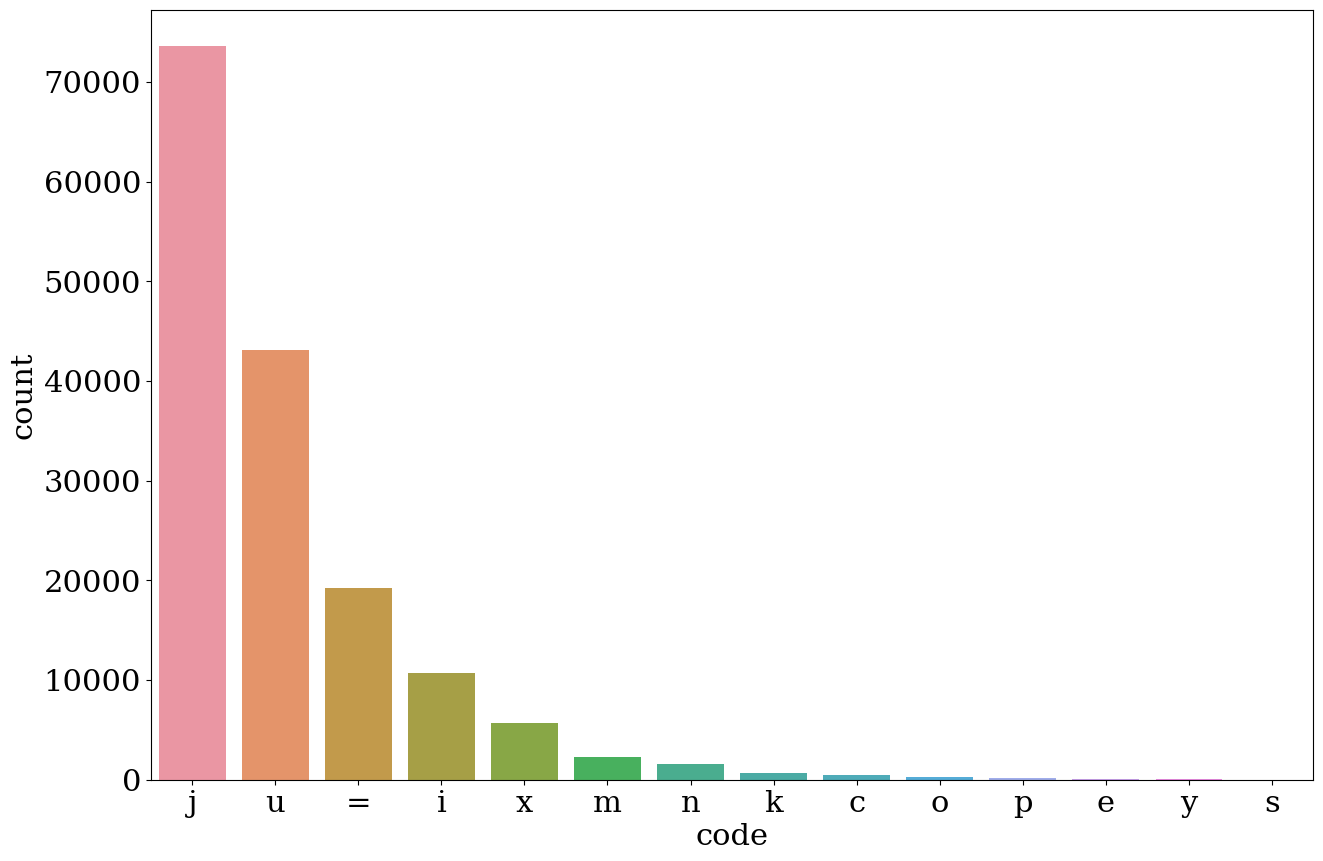

In [40]:
# need gffcompare codes of the transcripts compared to mane

# do only for mane loci

codes = definitions.get_attribute(out_dir+"gffcmp/MANE_CHESS3.annotated.gtf","code")
sns.countplot(x=codes["code"],order = codes['code'].value_counts().index)

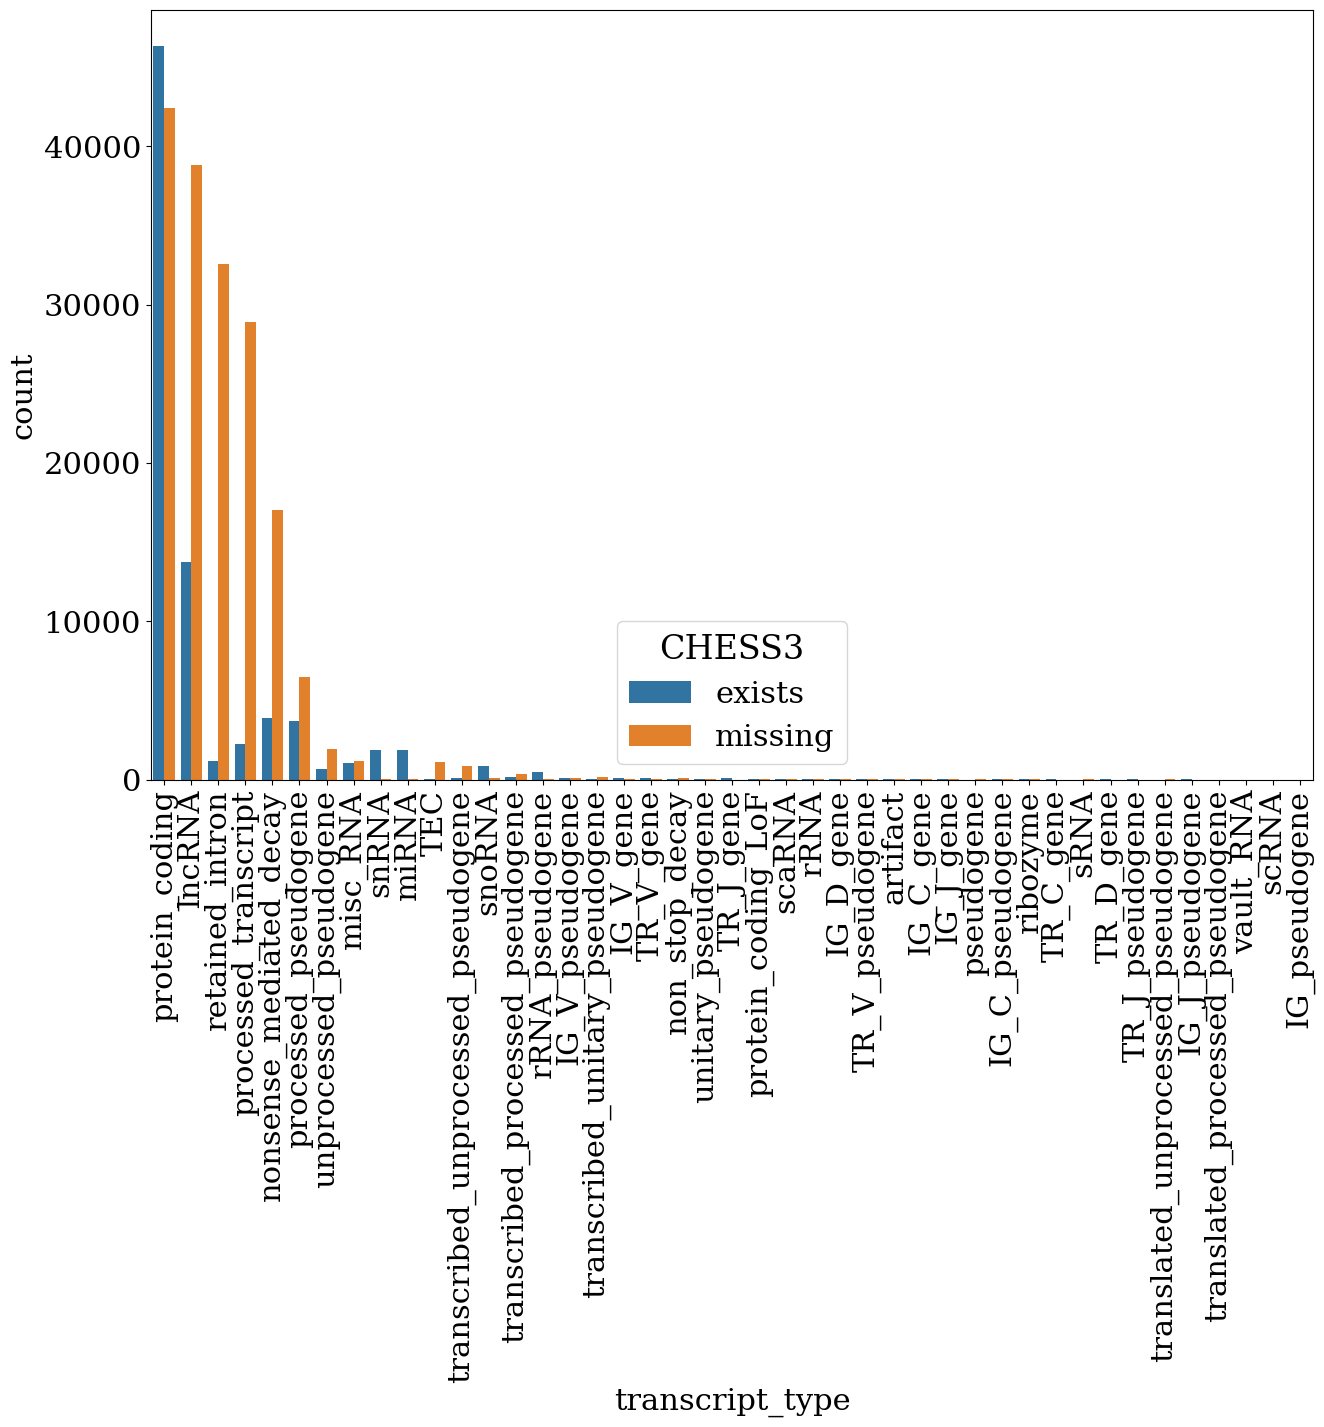

In [41]:
# reviewer 2 comment 3 : get labels of the gencode and refseq transcripts which we do not include in chess

# load tids of refseq and gencode transcripts without match
refseq_codes = definitions.get_attribute(out_dir+"gffcmp/CHESS3_RefSeq.annotated.gtf","code")
gencode_codes = definitions.get_attribute(out_dir+"gffcmp/CHESS3_GENCODE.annotated.gtf","code")

missing_refseq = set(refseq_codes[~(refseq_codes["code"]=="=")]["tid"])
missing_gencode = set(gencode_codes[~(gencode_codes["code"]=="=")]["tid"])

# gencode transcript_type
gencode_ttypes = definitions.get_attribute(gencode_gtf_fname,"transcript_type")
gencode_ttypes["CHESS3"] = np.where(gencode_ttypes["tid"].isin(missing_gencode),"missing","exists")

ax = sns.countplot(data=gencode_ttypes, x="transcript_type", hue="CHESS3",order = gencode_ttypes['transcript_type'].value_counts().index)
ax.tick_params(axis='x', labelrotation=90)

# for refseq - not sure what attribute to choose since no transcript_type. At the same time we already showed the difference in XM/NM transcripts before and 
# that we include most things at least in coding genes

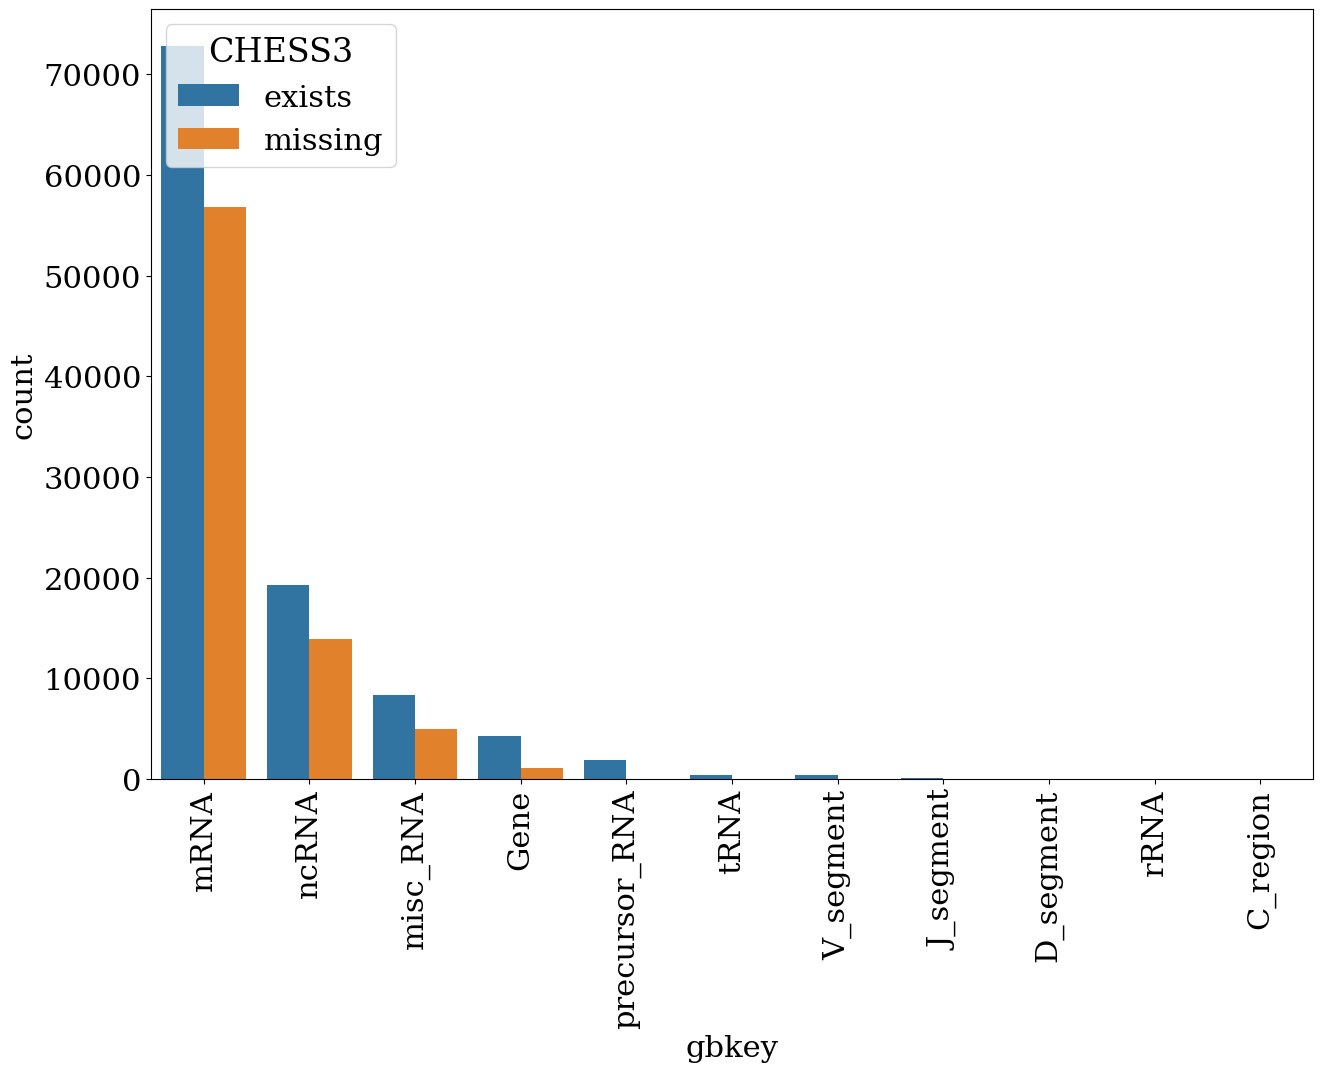

In [42]:
# refseq transcript_type
refseq_gtypes = definitions.get_attribute(refseq_gtf_fname,"gbkey")
refseq_gtypes["CHESS3"] = np.where(refseq_gtypes["tid"].isin(missing_refseq),"missing","exists")

ax = sns.countplot(data=refseq_gtypes, x="gbkey", hue="CHESS3",order = refseq_gtypes['gbkey'].value_counts().index)
ax.tick_params(axis='x', labelrotation=90)
